#### Configure script.

We set global variables that define behaviour of this script.

In [1]:
# DELETE THESE IF NOT NEEDED??????????????????
#DATA_DIR = "../data/"   # directory where data files are located (not tracked by git for data protection reasons)
#COLUMNS = None          # specifiy which columns to use for prediction, otherwise use defaults.
#DATA_FILE = ""

DATA = "CAP"
#DATA = "LeDeR"
#DATA = "Temporary"

RANDOM_STATE = 40
TEST_SIZE = 0.2

####### MAKE THIS CONDITIONAL ON CAP/LEDER....
CLASSIFIER_LABEL = 'pca_death_code'
#CLASSIFIER_LABEL = 'Poor_practice_flag'

LOAD_CLASSIFIER_FILENAME = 'cap_rf_gridsearch_090920_2.joblib'
# use this if no better than 99 -> 92% SAVE_CLASSIFIER_FILENAME = 'cap_rf_gridsearch_030920.joblib'
#SAVE_CLASSIFIER_FILENAME = 'cap_rf_gridsearch_090920_2.joblib'

PARAMETERS = {
    'clf__n_estimators': (500,1000),
    'clf__max_features': (0.1,0.2,),
    #'clf__max_depth': (5,10,15),
    'clf__max_depth': (15,),
    'clf__max_samples': (0.7,0.8,0.9),# 0.8, 0.99),
    'clf__min_samples_leaf': (2,3),
    #'clf__n_estimators': (100,),
    #'clf__max_samples': (0.8,),
    'vect__ngram_range': ((1, 2),),
    'vect__max_df': (0.7,),
    'vect__min_df': (5,),
    'vect__max_features': (1500,),
}
CV = 3
#SCORING = 'balanced_accuracy'
SCORING = None #'accuracy'

In [2]:
import pandas as pd
from joblib import dump, load

import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss, precision_score, recall_score, f1_score

from helper import (pd_print, 
                    accuracy,
                    lemmatize_text,
                    summarise_gridsearch_classifier,
                    calibrate_random_forest, 
                    plot_calibration_curve,
                    plot_calibration_curve_easy_hard,
                    plot_roc_curve,
                    compute_all_metrics)

from explainability import (get_rf_feature_importances,
                            wordcloud,
                            run_tree_interpreter,
                            get_ti_feature_contributions_for_instance_i,
                            get_ti_feature_contributions_average)

import matplotlib.pyplot as plt
%matplotlib inline

## temporary:
import pickle

C:\Users\cm1788\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.ensemble.forest module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.ensemble. Anything that cannot be imported from sklearn.ensemble is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
if DATA == "CAP":
    
    from cap_helper import *
    
    print("Working with CAP prostate cancer data.")
    df = load_data()
    # Combine text from all feature columns into a single string column
    df = concatenate_feature_columns(df)
    # Link to dates of death:
    df = add_dates(df)
    # Link to reviewer Ids:
    df = add_reviewer_ids(df)
    # Convert all dates to be in units of months before/after death (Note: this regex is not foolproof)
    df = convert_dates_relative(df)  
    
    # The reviews are dominated by three authors:
    pd_print(get_reviewer_counts(df))
    
    with open('temp_data.pickle', 'wb') as outfile:
        pickle.dump(df, outfile)
    
elif DATA == "LeDeR":
    
    from leder_helper import *
    
    print("Working with LeDeR learning disabilities mortality data.")
    df = load_data()
    # Construct flags to indicate 'poor' and 'good' practice:
    df = build_labels(df)
    # Combine text from all feature columns into a single string column
    df = concatenate_feature_columns(df)
    
    # Note that evidence for poor and good practice can coexist, and some cases have neither:
    pd_print(get_practice_counts(df))
    pd_print(get_reviewer_counts(df))

    
## Temporary:
else:
    with open('temp_data.pickle', 'rb') as infile:
        df = pickle.load(infile)    

Working with CAP prostate cancer data.


,number of reviews
vig_author,
1.0,890
2.0,7
3.0,636
4.0,80
5.0,712
6.0,54
7.0,3
8.0,78
9.0,2


#### Having loaded and pre-processed the data we can start to train classifiers:

In [4]:
stemmer = WordNetLemmatizer()

In [5]:
X,y = df.combined, df[CLASSIFIER_LABEL]

In [6]:
documents = lemmatize_text(X, stemmer)

In [7]:
print(len(y[y==1]))
print(len(y[y==2]))

1098
1512


In [8]:
pipeline = Pipeline([
    ('vect', CountVectorizer(stop_words=stopwords.words('english'))),
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestClassifier(random_state=RANDOM_STATE)),
])

In [9]:
X_train, X_test, y_train, y_test = train_test_split(documents, 
                                                    df[CLASSIFIER_LABEL], 
                                                    test_size=TEST_SIZE, 
                                                    random_state=RANDOM_STATE)

In [10]:
if LOAD_CLASSIFIER_FILENAME is not None:
    clf = load('models/' + LOAD_CLASSIFIER_FILENAME)
    
else:
    clf = GridSearchCV(pipeline, PARAMETERS, n_jobs=-1, verbose=1, cv=CV, scoring=SCORING)
    clf.fit(X_train, y_train)
    
    if SAVE_CLASSIFIER_FILENAME is not None:
        dump(clf, 'models/' + SAVE_CLASSIFIER_FILENAME)

In [11]:
summarise_gridsearch_classifier(clf)

Best score: 0.914
Best parameters set:
	clf__bootstrap: True
	clf__ccp_alpha: 0.0
	clf__class_weight: None
	clf__criterion: 'gini'
	clf__max_depth: 15
	clf__max_features: 0.2
	clf__max_leaf_nodes: None
	clf__max_samples: 0.7
	clf__min_impurity_decrease: 0.0
	clf__min_impurity_split: None
	clf__min_samples_leaf: 2
	clf__min_samples_split: 2
	clf__min_weight_fraction_leaf: 0.0
	clf__n_estimators: 1000
	clf__n_jobs: None
	clf__oob_score: False
	clf__random_state: 40
	clf__verbose: 0
	clf__warm_start: False
	tfidf__norm: 'l2'
	tfidf__smooth_idf: True
	tfidf__sublinear_tf: False
	tfidf__use_idf: True
	vect__analyzer: 'word'
	vect__binary: False
	vect__decode_error: 'strict'
	vect__dtype: <class 'numpy.int64'>
	vect__encoding: 'utf-8'
	vect__input: 'content'
	vect__lowercase: True
	vect__max_df: 0.7
	vect__max_features: 1500
	vect__min_df: 5
	vect__ngram_range: (1, 2)
	vect__preprocessor: None
	vect__stop_words: ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "

In [12]:
accuracy(clf, X_train, y_train, name='Train');
accuracy(clf, X_test, y_test);

Train Accuracy: 99.33%
Test Accuracy: 93.10%


Note: Change positive class label for LeDeR

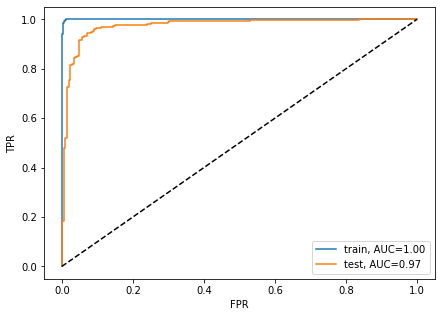

In [13]:
plot_roc_curve(clf, X_train, y_train, X_test, y_test, "train", "test", pos_label=2)

#### Calibration:

In [14]:
calibrated_clf = calibrate_random_forest(X_train, y_train)

Fitting 10 folds for each of 3 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   31.4s finished


Random forest:
	Brier: 0.075
	Precision: 0.881
	Recall: 0.914
	F1: 0.897

Random forest + Sigmoid:
	Brier: 0.064
	Precision: 0.896
	Recall: 0.900
	F1: 0.898



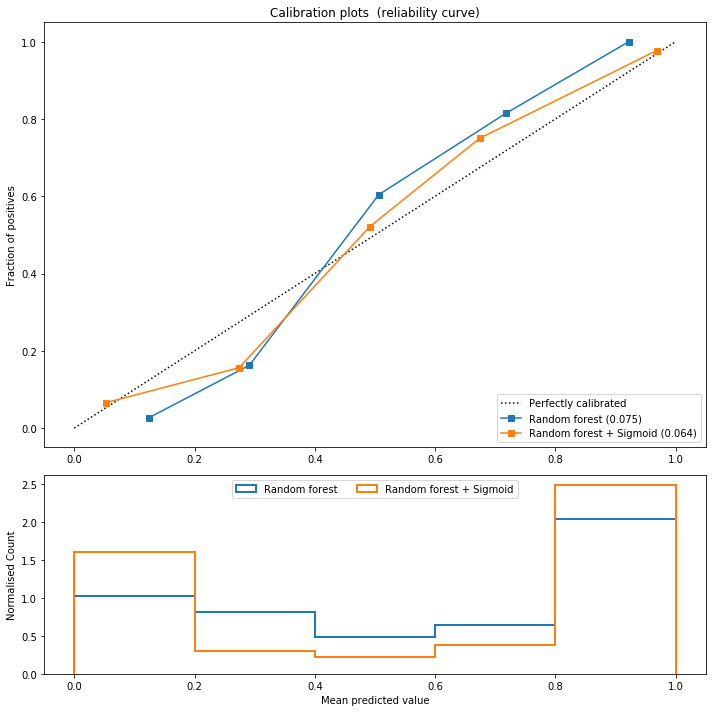

In [15]:
plot_calibration_curve(clf, calibrated_clf, X_test, y_test)

#### Easy and hard cases currently defined only for CAP:

easy cases:
	Brier: 0.043
	Precision: 0.957
	Recall: 0.912
	F1: 0.934

hard cases:
	Brier: 0.236
	Precision: 0.481
	Recall: 0.765
	F1: 0.591



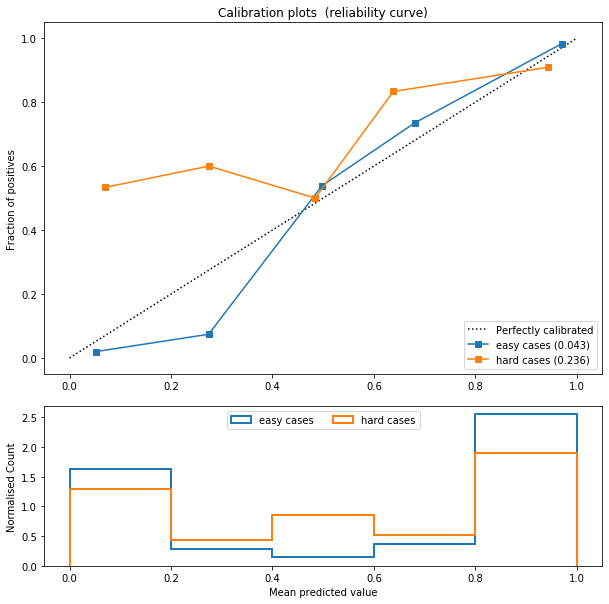

In [16]:
from cap_helper import get_easy_and_hard_cases
easy_x, hard_x, easy_y, hard_y = get_easy_and_hard_cases(df, subset_x=X_test, subset_y=y_test)
plot_calibration_curve_easy_hard(calibrated_clf, easy_x, hard_x, easy_y, hard_y)

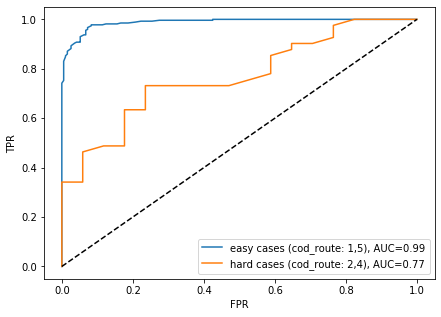

In [17]:
plot_roc_curve(clf, easy_x, easy_y, hard_x, hard_y, 'easy cases (cod_route: 1,5)', 'hard cases (cod_route: 2,4)', )

#### All metrics:

In [18]:
performance = compute_all_metrics(clf, X_train, y_train, X_test, y_test, 'train', 'test')
performance

,metric,train,test
0,AUC,1.0,0.972459
1,Accuracy,100.0,91.570881
2,Precision,1.0,0.880734
3,Recall,1.0,0.914286
4,F1,1.0,0.897196


### To add (possibly):

 - ROC curves
 - tSNE of feature spcae

 
 ### Additional (maybe at end of script?):
 
 - Try to classify hard cases (show for SI)
 - produce authorship figures and anaylis for SI
 - produce list of text fields present in CAP and LeDeR (also get numbers for LeDeR table 1)

## Now for Explainability:

In [13]:
fimps = get_rf_feature_importances(clf)
assert fimps.feature.is_unique
fimps.head(15)

,feature,contribution,magnitude
298,bone scan,0.027978,0.027978
1281,spine,0.025727,0.025727
651,hormone,0.025590,0.025590
287,blockade,0.024905,0.024905
491,docetaxel,0.019362,0.019362
212,androgen blockade,0.019029,0.019029
211,androgen,0.018208,0.018208
1483,widespread,0.015373,0.015373
1198,scan,0.015237,0.015237
1208,sclerotic,0.014452,0.014452


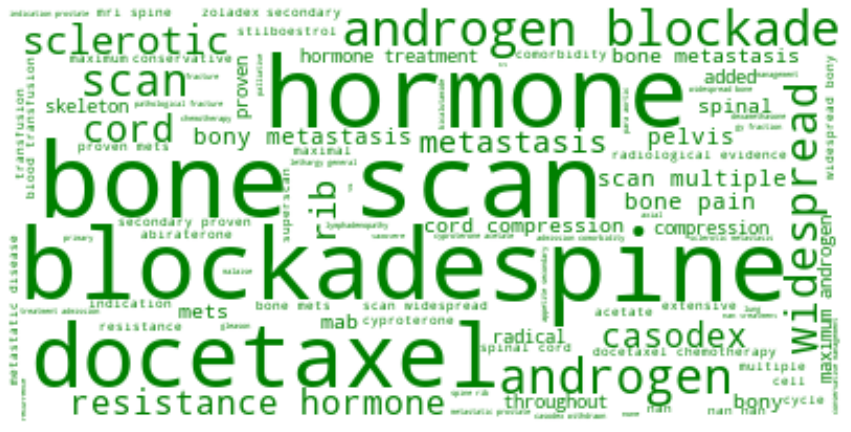

In [14]:
wordcloud(fimps)

# Use a different example!!

In [15]:
prediction, bias, contributions = run_tree_interpreter(clf, X_test)
ti_fimps_i = get_ti_feature_contributions_for_instance_i(3, contributions, clf)

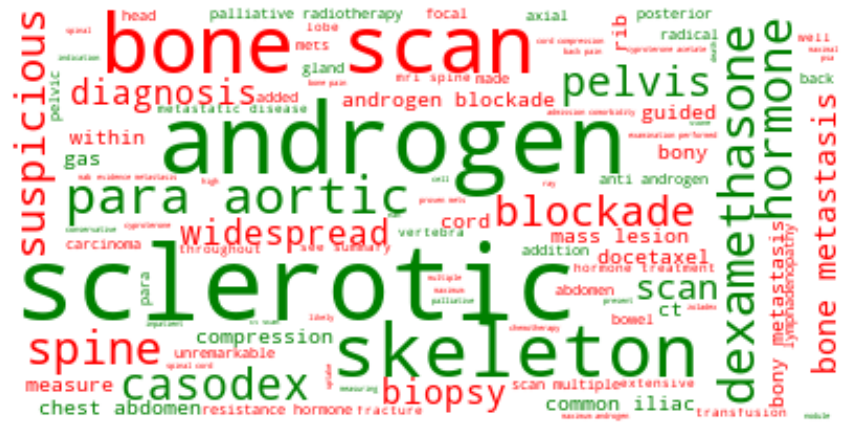

In [16]:
wordcloud(ti_fimps_i)

In [17]:
ti_fimps = get_ti_feature_contributions_average(contributions, clf)

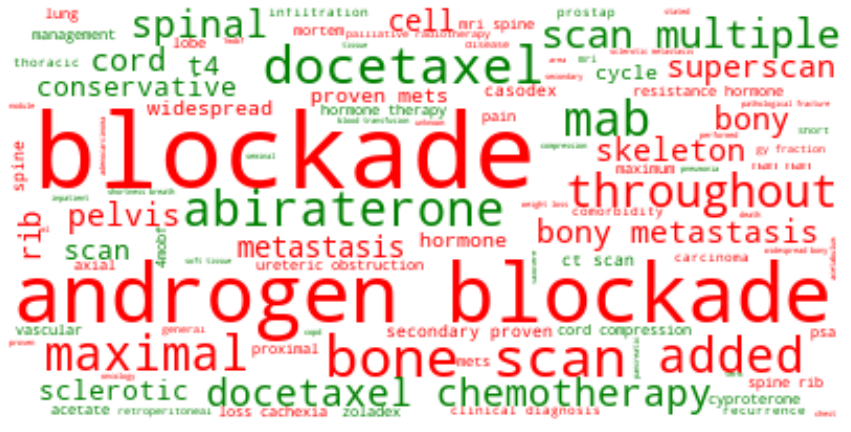

In [18]:
wordcloud(ti_fimps)

In [19]:
ti_fimps.sort_values('magnitude', ascending=False)

,feature,contribution,magnitude
287,blockade,-0.002868,0.002868
212,androgen blockade,-0.002323,0.002323
298,bone scan,-0.000948,0.000948
491,docetaxel,0.000851,0.000851
171,abiraterone,0.000807,0.000807
...,...,...,...
909,ml 2mobf,0.000000,0.000000
22,10 12,0.000000,0.000000
997,oncology clinic,0.000000,0.000000
701,infiltrated,0.000000,0.000000


## To add:

* LIME from FATF
* make notes on word clouds e.g. what do the colours represent etc

In [20]:
original_data = df.loc[y_test.index[86]]

In [21]:
feature_columns = df.columns[2:27]

In [22]:
from interpretable_pdf import InterpretablePDF

In [23]:
ipdf = InterpretablePDF(clf, X_test, y_test, feature_columns)

In [24]:
ipdf.create_pdf(86, original_data, "test.pdf")

In [25]:
fimp = ti_fimps.loc[ti_fimps.contribution < 0]

In [26]:
fimp

,feature,contribution,magnitude
1,02,-0.000067,0.000067
3,03,-0.000146,0.000146
4,04,-0.000029,0.000029
5,05,-0.000016,0.000016
6,06,-0.000050,0.000050
...,...,...,...
1491,within right,-0.000040,0.000040
1492,without,-0.000005,0.000005
1493,worsening,-0.000009,0.000009
1494,would,-0.000108,0.000108


## TO DO:

* refactor InterpeetablePDF code
* see todo list in: replacing_dates_and_cleaning_pdf_output
* prdouce some example pdfs for publication (and visualise the head of them here)